---
# **機械学習特論　第8回課題**
## **【カルマンフィルタ】さいたま市における月別降水量の予測**
---

In [30]:
# ライブラリの読み込み
# %pip install --upgrade pip
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install openpyxl
# %pip install sympy
# %pip install scipy
# %pip install re
# %pip install jaconv
# %pip install scikit-learn
# %pip install statsmodels
# %pip install seaborn
# %pip install pmdarima
# %pip install kneed
# %pip install scikit-learn-intelex
# %pip install lightgbm
# %pip install pykalman
# %pip install filterpy

from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import sympy as sp
import scipy.stats as stats
import re
import jaconv 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import itertools
import matplotlib.dates as mdates
import pmdarima as pm
from IPython.display import clear_output
from sklearn.metrics import r2_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import time
from matplotlib.ticker import LogLocator, LogFormatter
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearnex import patch_sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import os
import pykalman
from statsmodels.tsa.seasonal import seasonal_decompose
from filterpy.kalman import KalmanFilter
import statsmodels

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='seaborn')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)


### 1. 課題
#### (1) データセット
　さいたま市における気象データより，月別降水量を用いる．

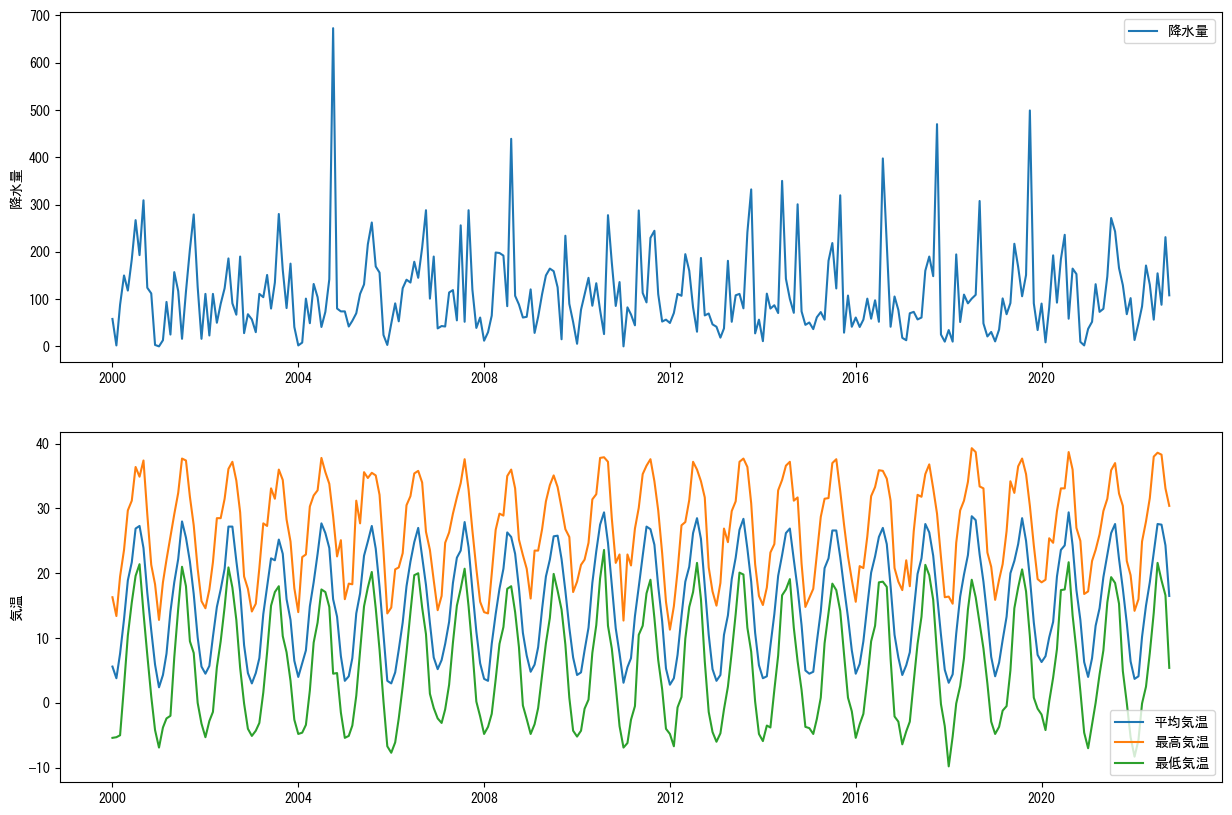

In [31]:
# さいたま市の気象データのデータフレームを作成
url = 'ml08_saitama_monthly_weather_data.xlsx'
df = pd.read_excel(url)
x_label = '年月'
y_label = '降水量'

plt.rcParams['font.family'] = 'MS Gothic'
fig, ax = plt.subplots(2, 1, figsize=(15,10)) # 折れ線グラフで表示
g = ax[0].set_ylabel(y_label)
g = ax[0].plot(df['年月'], df['降水量'], label='降水量')
g = ax[0].legend()
g = ax[1].set_ylabel('気温')
g = ax[1].plot(df['年月'], df['平均気温'], label='平均気温')
g = ax[1].plot(df['年月'], df['最高気温'], label='最高気温')
g = ax[1].plot(df['年月'], df['最低気温'], label='最低気温')
g = ax[1].legend()


#### (2) データの成分分解
　時系列データをトレンド成分，周期成分，ノイズ成分に分解する．

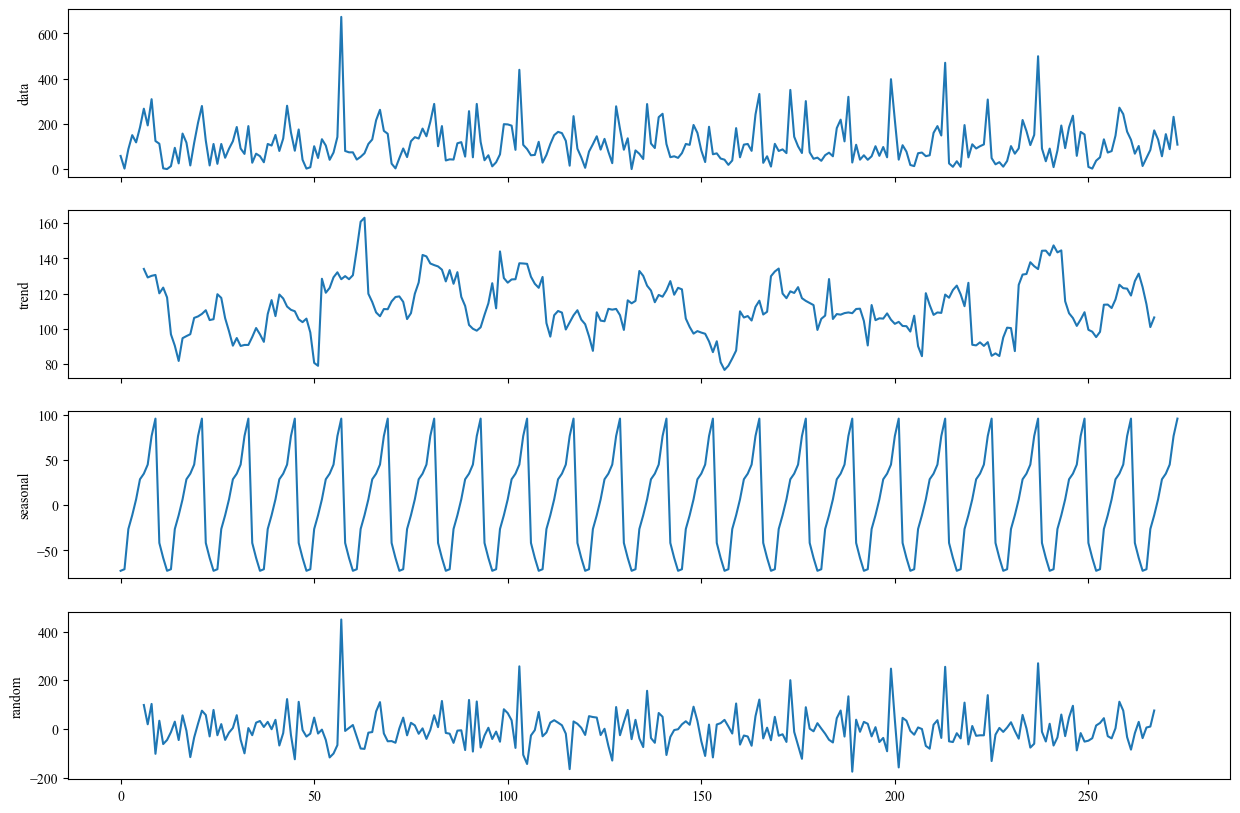

In [32]:
# 時系列データの成分分解（data -> tread, seasonal, random）
data = df[y_label].values
plt.rcParams['font.family'] = 'Times New Roman'
pm.utils.decomposed_plot(pm.arima.decompose(data,'additive',m=12),
                                figure_kwargs = {'figsize': (15, 10)} )

#### (3) データの分割
　データを学習用と検証用に分ける．

252 22 274


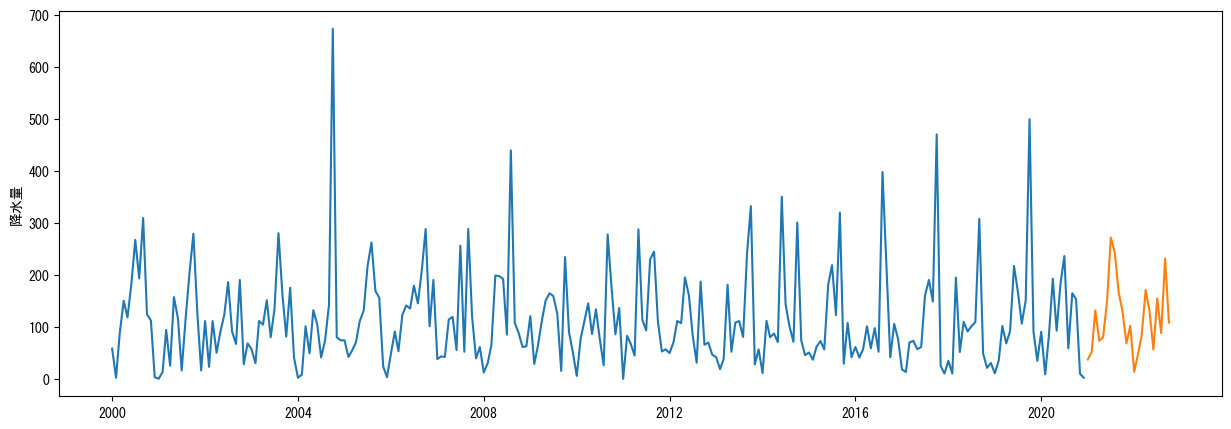

In [33]:
# 時系列モデルの学習と性能検証のため、データを学習用(先頭から252件)と検証用(253件目以降)に分割
num_train = 252
train_data = df[:num_train]
test_data = df[num_train:]
print(len(train_data), len(test_data), len(df))
plt.rcParams['font.family'] = 'MS Gothic'
fig, ax = plt.subplots(1, 1, figsize=(15,5)) # 折れ線グラフで表示
g = ax.set_ylabel(y_label)
g = ax.plot(train_data[x_label], train_data[y_label])
g = ax.plot(test_data[x_label], test_data[y_label])

#### (4) ADF検定
　ADF検定より，データが定常状態であるか検定する．

(-6.758949129951256, 2.8243409807328767e-09, 10, 241, {'1%': -3.4577787098622674, '5%': -2.873608704758507, '10%': -2.573201765981991}, 2775.361855636463)


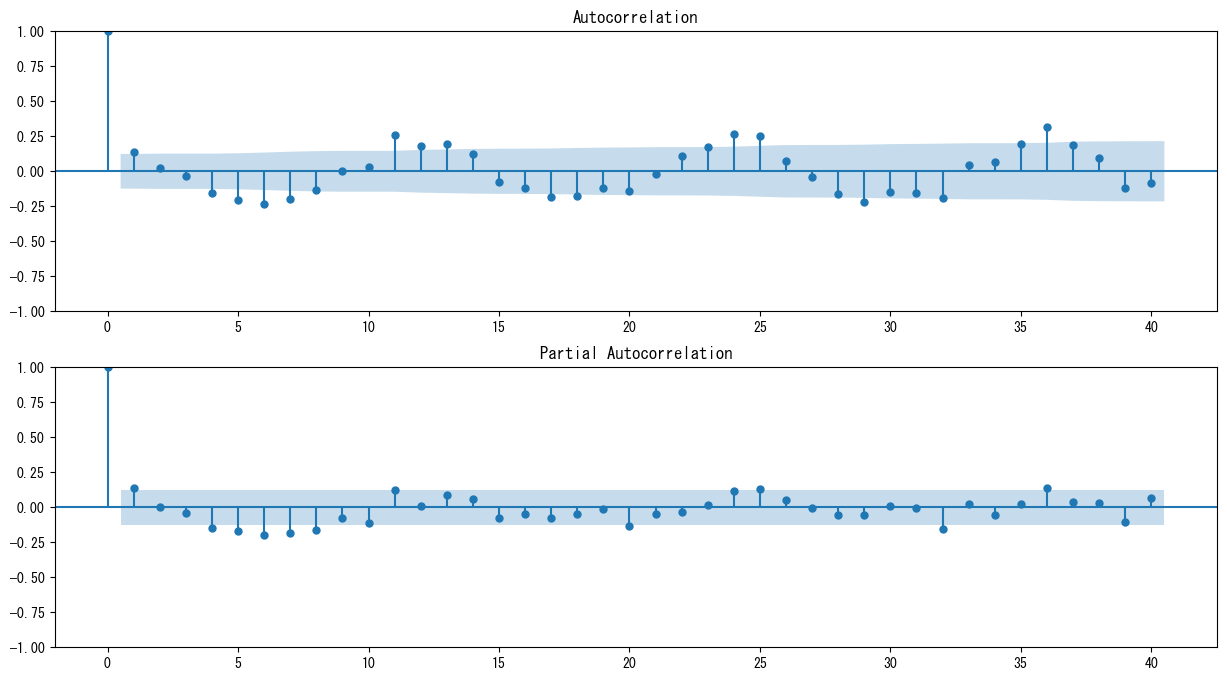

In [34]:
# 単位根検定 -> 先頭から、検定値、P値 の順で出力される (P値が 0.05より大きい場合、単位根AR(p)過程でないとはいえない)
print(sm.tsa.stattools.adfuller(train_data[y_label].values))

# コレログラム（自己相関と偏自己相関）を表示
data = train_data[y_label].values
fig, ax = plt.subplots(2, 1, figsize=(15,8))
fig = statsmodels.api.graphics.tsa.plot_acf(data, lags=40, ax=ax[0])
fig = statsmodels.api.graphics.tsa.plot_pacf(data, lags=40, ax=ax[1], method='ywm')

結果より，1%有意水準でも帰無仮説を棄却することができ，データは定常状態であるといえる．したがって，差分を取らずに時系列モデル（ARIMAモデル）を適用することが適切であると考えられる．

#### (5) ARIMAモデルによる予測

 ARIMA(0,0,0)(2,0,1)[12] intercept
train_data MAE: 56.84229260627589
train_data MSE: 6560.6930414926155
test_data MAE: 42.032846972881835
test_data MSE: 3222.4995392287224


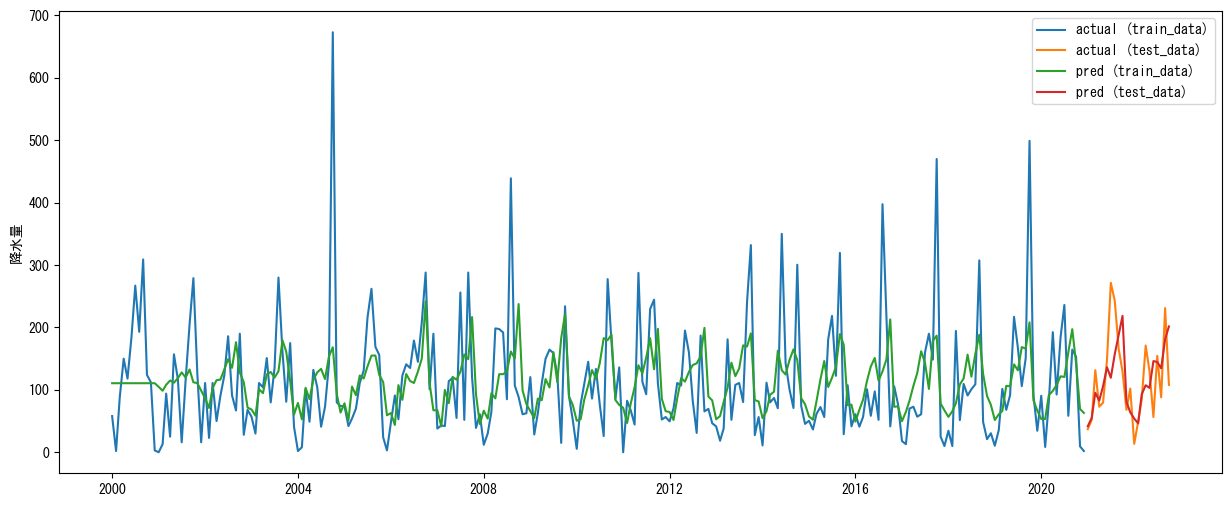

In [35]:
# 次数探索を行い、最適次数でモデルを作成し、学習データで学習
auto_model = pm.auto_arima(train_data[y_label].values, seasonal=True, m=12)
print(auto_model)

##学習データの期間の予測値と、その平均絶対誤差(MAE)と平均二乗誤差(MSE)
train_pred = auto_model.predict_in_sample()
print('train_data MAE:', mean_absolute_error(train_data[y_label].values, train_pred))
print('train_data MSE:', mean_squared_error(train_data[y_label].values, train_pred))
##テストデータの期間の予測値と予測区間(95%信頼区間)と、その平均絶対誤差(MAE)と平均二乗誤差(MSE)
test_pred, test_pred_ci = auto_model.predict(n_periods=test_data.shape[0], return_conf_int=True)
print('test_data MAE:', mean_absolute_error(test_data[y_label].values, test_pred))
print('test_data MSE:', mean_squared_error(test_data[y_label].values, test_pred))

# 観測値と予測値をグラフで表示 (見やすくするために、2016年7月以降を表示)
plt.rcParams['font.family'] = 'MS Gothic'
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.set_ylabel(y_label)
g = ax.plot(train_data[0:][x_label], train_data[0:][y_label], label="actual (train_data)")
g = ax.plot(test_data[x_label], test_data[y_label], label="actual (test_data)")
g = ax.plot(train_data[0:][x_label], train_pred[0:], label="pred (train_data)")
g = ax.plot(test_data[x_label], test_pred, label="pred (test_data)")
g = ax.legend()

　学習用データへのフィットはあまり良くないが，全体の周期成分をよく捉え，検証用データに対して上手くフィットした．

#### (6) カルマンフィルタによる予測
　カルマンフィルタとは，推定したい状態変数を含む状態量ベクトル $\bm{x}$ を，ノイズが含まれる観測値ベクトル $\bm{y}$ から推定するための再帰的アルゴリズムである．
- **再帰的計算**: 観測データが順次得られるたびに計算を行うため，計算効率が高い
- **状態推定**: 時間的に変化するシステムの内部状態を推定
- **ノイズの低減**: 観測ノイズやシステムノイズを考慮した信頼性の高い推定  

　カルマンフィルタのアルゴリズムは2つのステップに分類され，1つ目は時刻$k-1$までの状態量を用い状態モデルに基づいて時刻$k$の状態量を事前予測するステップで，2つ目は，時刻$k$の観測値を用いて事前推定をフィルタ（更新）（事後推定）するステップである．  

(1) 予測ステップ (Prediction)  
　時刻$k$における状態量ベクトル $\bm{x}_k$ は時刻$k-1$までの状態量ベクトル $\bm{x}_{k-1}$ とシステムへの入力ベクトル $\bm{u}_{k}$ ，共分散行列 $\bm{Q}_k$ の多変数標準正規分布に従うと仮定されるノイズベクトル $\bm{w}_k$ を用いて，以下のような状態方程式で表される．ただし，$\bm{A}$ や $\bm{B}$ は係数行列である．  
$$
\bm{x}_{k} = \bm{A} \bm{x}_{k-1} + \bm{u}_{k} + \bm{B} \bm{w}_{k}
$$
　一方で，時刻 $k$ における観測値ベクトル $\bm{y}$ は係数行列 $\bm{C}$ と共分散行列 $\bm{R}_k$ の多変数標準正規分布に従うと仮定されるノイズベクトル $\bm{v}_k$ を用いて，以下のような状態方程式で表される．
$$
\bm{y}_{k} = \bm{C} \bm{x}_{k} \bm{v}_{k}
$$  
　これより，時刻 $k$ における事前推定値 $\bm{\hat{x}}^{-}_{k}$ は以下のように表される．
$$
\bm{\hat{x}}^{-}_{k} = \bm{A} \bm{\hat{x}}_{k-1} + \bm{u}_{k}
$$
このとき，時刻 $k$ における予測の不確かさ（誤差）を意味する事前推定誤差共分散行列 $\bm{P}^{-}_{k}$ は，時刻 $k-1$ における事後推定誤差共分散行列 $\bm{P}_{k-1}$ を用いて，次式のように書ける．
$$
\bm{P}^{-}_{k} = \bm{A} \bm{P}_{k-1} \bm{A}^{T} + \bm{B} \bm{Q}_{k} \bm{B}^{T}
$$
これは，カルマンフィルタが時刻 $k$ における状態量ベクトル $\bm{x}_k$ とその事後推定値 $\bm{\hat{x}}_k$ の誤差を最小にすることを目的としているためであり，しかしながら，状態量ベクトル $\bm{x}_k$ にはノイズ（ばらつき）が含まれるため，期待値を用いて $\text{E}[||\bm{x}_k - \bm{\hat{x}}_k||^2]$ の最小化を図るためである．係数のある変数の期待値を考えるとき，係数は2乗で影響するため，各項には係数行列の2乗があることが確認できる．  
　以上が予測ステップである．

(2) 更新ステップ (Update)  
　時刻$k$における事後推定値 $\bm{\hat{x}}_{k}$ は，事前推定値 $\bm{\hat{x}}^{-}_{k}$ と，観測値ベクトル $\bm{y}$ を$1-K:K$の重み付き平均で更新するとすれば，この比を単位行列 $\bm{I}$ と係数行列 $\bm{K}$ で拡張し，以下のように書ける．
$$
\bm{\hat{x}}_{k} = (\bm{I} - \bm{K}) \bm{\hat{x}}^{-}_{k} + \bm{K} \bm{y}
$$
これを変形し，係数行列 $\bm{C}$ の影響を考えると，次式が得られる．
$$
\bm{\hat{x}}_{k} = \bm{\hat{x}}^{-}_{k} + \bm{K} (\bm{y} - \bm{C} \bm{\hat{x}}^{-}_{k})
$$
この係数行列 $\bm{K}$ をカルマンゲインと呼び，カルマンフィルタの目的である期待値 $\text{E}[||\bm{x}_k - \bm{\hat{x}}_k||^2]$ の最小化にしたがって解くと，カルマンゲイン $\bm{K}$ は次のように定義される．
$$
\bm{K}_{k} = \bm{P}^{-}_{k} \bm{C}^{T} (\bm{R}_{k} + \bm{C} \bm{\hat{P}}^{-}_{k} \bm{C}^{T})^{-1}
$$
式を見ると，逆行列の部分が観測値の不確かさになっており，カルマンゲイン自体は観測値の確からしさを意味することが確認でき，観測値ベクトルの重みとなっていることと併せて理解できる．
　最後に時刻 $k$ における事後推定誤差共分散行列 $\bm{P}_{k}$ を更新する．
$$
\bm{P}_{k} = (\bm{I} - \bm{K}_{k} \bm{C}) \bm{P}^{-}_{k}
$$
　以上が更新ステップである．


train_data MAE: 3.204721999615044
train_data MSE: 21.081356611137224
test_data MAE: 39.12840681113916
test_data MSE: 2766.0556592034222


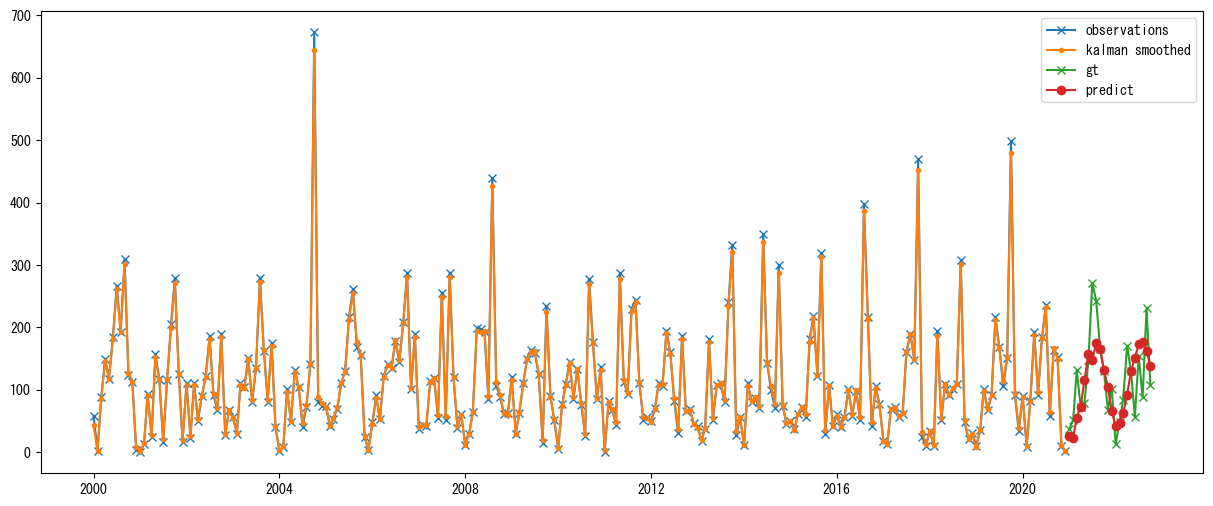

In [36]:
# 推移行列などの初期化
## 島田直樹、時系列解析(共立出版)のサンプルコートから引用
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend!=0) + (n_dim_series!=0)
    if n_dim_series>0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend
    
    # 行列の初期化
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    ## トレンドモデルのブロック行列の構築
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend==1: 
        F[0,0] = 1
    elif n_dim_trend==2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend==3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    # 季節調整成分のブロック行列の構築
    if n_dim_series>0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series-1): 
            F[start_elem, start_elem+i] = -1
        for i in range(n_dim_series-2): 
            F[start_elem+i+1, start_elem+i] = 1
    
    # PyKalmanのQはG.dot(Q).dot(G.T)を想定しているためQをupdate
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

# プログラムを見やすくするために観測値の変数を用意
observations = train_data[y_label].values

# カルマンフィルタを作成
n_dim_state, F, H, Q = FGHset(2,1,12) # ハイパーパラメータを準備 (トレンドの次元数、観測値の次元数、季節成分の次元数)
kf = pykalman.KalmanFilter(transition_matrices=F,  # 状態の推移行列
                            transition_covariance=Q,  # 状態ノイズの分散共分散行列
                            observation_matrices=H)  # 観測値の行列
emed_kf = kf.em(observations, n_iter=10, em_vars='all')  # ハイパーパラメータを更新
smoothed_state_means, smoothed_state_covs = emed_kf.smooth(observations) # フィルタリング+平滑化
train_pred = smoothed_state_means.dot(H.T)

# カルマンフィルタで予測
test_pred = np.empty(len(test_data)) # 予測値を格納するベクトルを用意
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]
for i in range(len(test_data)):
    current_state, current_conv = emed_kf.filter_update(current_state, current_cov, observation=None)
    test_pred[i] = kf.observation_matrices.dot(current_state)

## 学習用データの区間と検証用データの区間の予測値の平均絶対誤差(MAE)と平均二乗誤差(MSE)
print('train_data MAE:', mean_absolute_error(train_data[y_label].values, train_pred))
print('train_data MSE:', mean_squared_error(train_data[y_label].values, train_pred))
print('test_data MAE:', mean_absolute_error(test_data[y_label].values, test_pred))
print('test_data MSE:', mean_squared_error(test_data[y_label].values, test_pred))

# 観測値と予測値をグラフで表示 (見やすくするために、2016年7月以降を表示)
plt.figure(figsize=(15, 6))
plt.plot(train_data[0:][x_label], observations[0:], marker='x', label="observations")
plt.plot(train_data[0:][x_label], train_pred[0:], marker='.', label="kalman smoothed")
plt.plot(test_data[x_label], test_data[y_label], marker='x', label="gt")
plt.plot(test_data[x_label], test_pred, marker='o', label="predict")
plt.legend()
plt.show()

　学習用データに正しくフィットし，検証用データに対してもARIMAモデルよりも誤差が低いことが確認できる．これは，データの持つノイズ成分が大きく，カルマンフィルタで予測できない部分の影響が現れたものと考えられる．

### 2. モデルの改良（高精度化）
#### (1) 標準化を用いたカルマンフィルタの適用
　カルマンフィルタの前後に標準化・逆標準化の処理を追加し，精度の変化を確認する．

train_data MAE: 16.722296263580084
train_data MSE: 433.88402738494136
test_data MAE: 38.16368917698555
test_data MSE: 2467.7118345611457


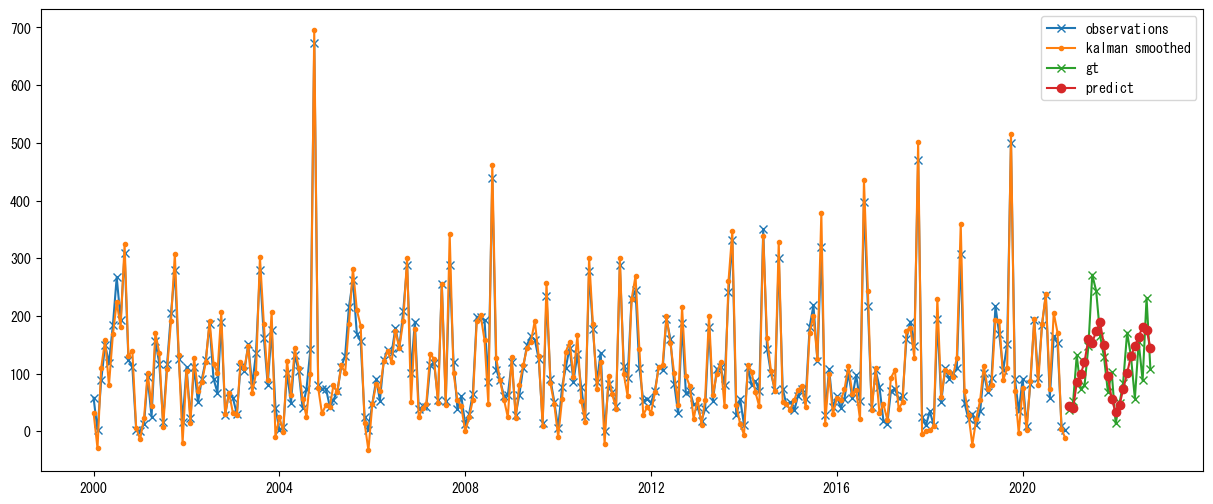

In [37]:
# 観測値の変数
observations = train_data[y_label].values

# データの標準化
scaler = StandardScaler()
observations_scaled = scaler.fit_transform(observations.reshape(-1, 1)).flatten()

# カルマンフィルタを作成
n_dim_state, F, H, Q = FGHset(2, 1, 12)  # ハイパーパラメータを準備 (トレンドの次元数、観測値の次元数、季節成分の次元数)
kf = pykalman.KalmanFilter(
    transition_matrices=F,  # 状態の推移行列
    transition_covariance=Q,  # 状態ノイズの分散共分散行列
    observation_matrices=H,  # 観測値の行列
)
emed_kf = kf.em(observations_scaled, n_iter=10, em_vars='all')  # ハイパーパラメータを更新
smoothed_state_means, smoothed_state_covs = emed_kf.smooth(observations_scaled)  # フィルタリング+平滑化
train_pred_scaled = smoothed_state_means.dot(H.T)

# 標準化を元に戻す (逆変換)
train_pred = scaler.inverse_transform(train_pred_scaled.flatten().reshape(-1, 1)).flatten()

# カルマンフィルタで予測
test_pred_scaled = np.empty(len(test_data))  # 標準化された予測値を格納するベクトルを用意
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]

for i in range(len(test_data)):
    current_state, current_conv = emed_kf.filter_update(current_state, current_cov, observation=None)
    test_pred_scaled[i] = kf.observation_matrices.dot(current_state)

# 標準化を元に戻す (逆変換)
test_pred = scaler.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# 学習用データの区間と検証用データの区間の予測値の平均絶対誤差(MAE)と平均二乗誤差(MSE)
print('train_data MAE:', mean_absolute_error(train_data[y_label].values, train_pred))
print('train_data MSE:', mean_squared_error(train_data[y_label].values, train_pred))
print('test_data MAE:', mean_absolute_error(test_data[y_label].values, test_pred))
print('test_data MSE:', mean_squared_error(test_data[y_label].values, test_pred))

# 観測値と予測値をグラフで表示 (見やすくするために、2016年7月以降を表示)
plt.figure(figsize=(15, 6))
plt.plot(train_data[0:][x_label], observations[0:], marker='x', label="observations")
plt.plot(train_data[0:][x_label], train_pred[0:], marker='.', label="kalman smoothed")
plt.plot(test_data[x_label], test_data[y_label], marker='x', label="gt")
plt.plot(test_data[x_label], test_pred, marker='o', label="predict")
plt.legend()
plt.show()


　標準化を加えることによって，精度が若干向上した．標準化なしでは学習用データのノイズ成分に大きく左右されていたものが改善された事による向上であると考えられる．しかし，パラメータは自動探索的に決定したわけではないため，本当に過学習の影響と言えるのか定かではない．

#### (2) ノイズ成分に対するパーティクルフィルタの適応
　ノイズの成分を正しく推定できればよいのではと考え，パーティクルフィルタを実装した．
　パーティクルフィルタの原理について詳しく説明することは控えるが，カルマンフィルタとの違いは時系列データに線形性を求めない（非線形でも可）ことと，ノイズにガウシアンノイズを仮定しないことが異なる．

train_data MAE: 2.513666387183231
train_data MSE: 13.837563764939565
test_data MAE: 40.65538232959698
test_data MSE: 2675.7051475161074


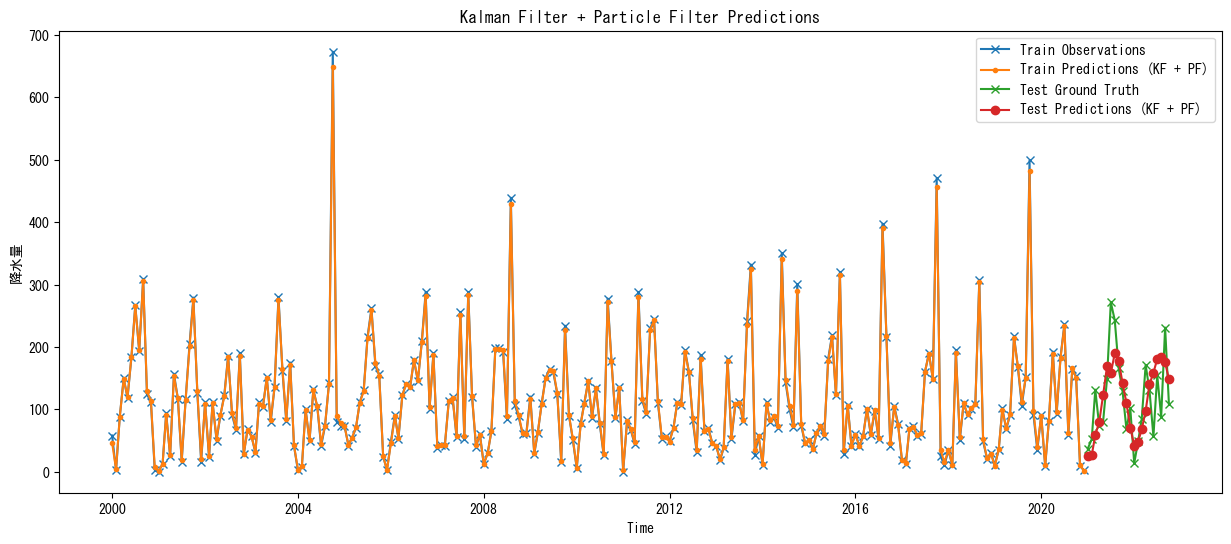

In [47]:
# パーティクルフィルタのクラス
class ParticleFilter:
    def __init__(self, n_particles, n_dim_state, transition_model, observation_model, process_noise, observation_noise):
        self.n_particles = n_particles
        self.n_dim_state = n_dim_state
        self.particles = np.random.randn(n_particles, n_dim_state)  # 初期化
        self.weights = np.ones(n_particles) / n_particles
        self.transition_model = transition_model
        self.observation_model = observation_model
        self.process_noise = process_noise
        self.observation_noise = observation_noise

    def predict(self):
        noise = np.random.multivariate_normal(np.zeros(self.n_dim_state), self.process_noise, self.n_particles)
        self.particles = self.transition_model(self.particles) + noise

    def update(self, observation):
        obs_pred = self.observation_model(self.particles)
        likelihood = np.exp(-0.5 * ((observation - obs_pred) ** 2) / self.observation_noise)
        self.weights *= likelihood
        self.weights += 1e-300  # underflow 対策
        self.weights /= np.sum(self.weights)

    def resample(self):
        indices = np.random.choice(range(self.n_particles), size=self.n_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.n_particles)

    def estimate(self):
        return np.average(self.particles, weights=self.weights, axis=0)

# カルマンフィルタの初期化
def FGHset(n_dim_trend, n_dim_obs=1, n_dim_series=0, Q_sigma2=10):
    n_dim_Q = (n_dim_trend != 0) + (n_dim_series != 0)
    if n_dim_series > 0:
        n_dim_state = n_dim_trend + n_dim_series - 1
    else:
        n_dim_state = n_dim_trend
    
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    G[0,0] = 1
    H[0,0] = 1
    if n_dim_trend == 1:
        F[0,0] = 1
    elif n_dim_trend == 2:
        F[0,0] = 2
        F[0,1] = -1
        F[1,0] = 1
    elif n_dim_trend == 3:
        F[0,0] = 3
        F[0,1] = -3
        F[0,2] = 1
        F[1,0] = 1
        F[2,1] = 1
        
    start_elem = n_dim_trend
    start_col = n_dim_trend
    if n_dim_series > 0:
        G[start_elem, 1] = 1
        H[0, start_elem] = 1
        for i in range(n_dim_series - 1): 
            F[start_elem, start_elem + i] = -1
        for i in range(n_dim_series - 2): 
            F[start_elem + i + 1, start_elem + i] = 1
    
    Q = G.dot(Q).dot(G.T)
    
    return n_dim_state, F, H, Q

# 観測値の取得
observations = train_data[y_label].values

# カルマンフィルタの作成
n_dim_state, F, H, Q = FGHset(2, 1, 12) # ハイパーパラメータを準備
kf = pykalman.KalmanFilter(transition_matrices=F,  # 状態の推移行列
                  transition_covariance=Q,  # 状態ノイズの分散共分散行列
                  observation_matrices=H)  # 観測値の行列
emed_kf = kf.em(observations, n_iter=10, em_vars='all')  # ハイパーパラメータを更新
smoothed_state_means, smoothed_state_covs = emed_kf.smooth(observations) # フィルタリング+平滑化
train_pred_kf = smoothed_state_means.dot(H.T)

# パーティクルフィルタの設定 (ノイズ成分の予測)
n_particles = 200
n_dim_noise = 1  # ノイズの次元数
process_noise = np.eye(n_dim_noise) * 1.0
observation_noise = 5

# ノイズ成分の遷移モデルと観測モデル
def transition_model(states):
    return states  # ノイズ成分の遷移はそのまま

def observation_model(states):
    return states[:, 0]  # ノイズ成分のみを観測

# パーティクルフィルタの初期化
pf = ParticleFilter(n_particles, n_dim_noise, transition_model, observation_model, process_noise, observation_noise)

# ノイズの推定 (パーティクルフィルタ)
train_pred_noise = np.empty(len(observations))
for t, obs in enumerate(observations):
    pf.predict()
    pf.update(obs - train_pred_kf[t])  # 観測値からカルマンフィルタによるトレンドを差し引く
    pf.resample()
    train_pred_noise[t] = pf.estimate()[0]

# ノイズをトレンドと合わせて最終的な予測を作成
train_pred_noise = train_pred_noise[:, np.newaxis]
train_pred_final = train_pred_kf + train_pred_noise

# テストデータにおける予測
test_pred_kf = np.empty(len(test_data))
test_pred_noise = np.empty(len(test_data))
current_state = smoothed_state_means[-1]
current_cov = smoothed_state_covs[-1]

for i, obs in enumerate(test_data[y_label].values):
    # カルマンフィルタによるトレンドの予測
    current_state, current_cov = emed_kf.filter_update(current_state, current_cov, observation=None)
    test_pred_kf[i] = kf.observation_matrices.dot(current_state)

    # パーティクルフィルタによるノイズの予測
    pf.predict()
    if i > 0:  # 時刻 k-1 の観測値との差分を使用
        residual = obs - test_pred_kf[i - 1]
        pf.update(residual)
    pf.resample()
    test_pred_noise[i] = pf.estimate()[0]

# トレンド予測とノイズ予測の合成
test_pred_final = test_pred_kf + test_pred_noise

# 評価指標の計算
print('train_data MAE:', mean_absolute_error(train_data[y_label].values, train_pred_final))
print('train_data MSE:', mean_squared_error(train_data[y_label].values, train_pred_final))
print('test_data MAE:', mean_absolute_error(test_data[y_label].values, test_pred_final))
print('test_data MSE:', mean_squared_error(test_data[y_label].values, test_pred_final))

# 結果のプロット
plt.figure(figsize=(15, 6))
plt.plot(train_data[x_label], observations, marker='x', label="Train Observations")
plt.plot(train_data[x_label], train_pred_final, marker='.', label="Train Predictions (KF + PF)")
plt.plot(test_data[x_label], test_data[y_label], marker='x', label="Test Ground Truth")
plt.plot(test_data[x_label], test_pred_final, marker='o', label="Test Predictions (KF + PF)")
plt.legend()
plt.xlabel("Time")
plt.ylabel(y_label)
plt.title("Kalman Filter + Particle Filter Predictions")
plt.show()

結果は，MAEはカルマンフィルタの方がよいが，MSEは改善した．これより，全体の誤差は悪化したものの，大きな誤差とならないようなモデルを構築できたと言える．これは大きな誤差の原因であったノイズ成分がパーティクルフィルタによってある程度正しく推定できたためであると考えられる．

| モデル             | train: MAE         | train: MSE         | train: MAE         | train: MSE         |
|--------------------|--------------------|--------------------|--------------------|--------------------|
| ARIMA              | 56.84229260627589  | 6560.6930414926155 | 42.032846972881835 | 3222.4995392287224 |
| Kalman             | 3.204721999615044  | 21.081356611137224 | 39.12840681113916  | 2766.0556592034222 |
| Kalman + stdScaler | 16.722296263580084 | 433.88402738494136 | 38.16368917698555  | 2467.7118345611457 |
| Kalman + Particle  | 2.513666387183231  | 13.837563764939565 | 40.65538232959698  | 2675.7051475161074 |

### 感想  
　カルマンフィルタはもともとモデルが分かっているものに適用するものであるため，パラメータを試行錯誤的に決定するのは間違いではないのかとも考えたが，クロスバリデーションなどで自動探索を行い，精度が良いモデルが得られば，一定範囲で有用であるとも感じた．